# Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import xgboost
import time
from joblib import dump, load
import os

# Load the data

In [40]:
df = pd.read_csv('final_data.csv')

In [41]:
df.columns

Index(['minute', 'position_name', 'shot_body_part_name', 'shot_technique_name',
       'shot_type_name', 'shot_first_time', 'shot_one_on_one',
       'shot_aerial_won', 'shot_open_goal', 'shot_follows_dribble',
       'shot_redirect', 'x1', 'y1', 'number_of_players_opponents',
       'number_of_players_teammates', 'is_goal', 'angle', 'distance',
       'x_player_opponent_Goalkeeper', 'x_player_opponent_8',
       'x_player_opponent_1', 'x_player_opponent_2', 'x_player_opponent_3',
       'x_player_teammate_1', 'x_player_opponent_4', 'x_player_opponent_5',
       'x_player_opponent_6', 'x_player_teammate_2', 'x_player_opponent_9',
       'x_player_opponent_10', 'x_player_opponent_11', 'x_player_teammate_3',
       'x_player_teammate_4', 'x_player_teammate_5', 'x_player_teammate_6',
       'x_player_teammate_7', 'x_player_teammate_8', 'x_player_teammate_9',
       'x_player_teammate_10', 'y_player_opponent_Goalkeeper',
       'y_player_opponent_8', 'y_player_opponent_1', 'y_player_oppone

In [42]:
df.head()

minute         position_name shot_body_part_name shot_technique_name  \
0       0  Right Center Forward          Right Foot              Normal   
1       5  Right Center Forward           Left Foot              Normal   
2       5       Center Midfield          Right Foot         Half Volley   
3       5  Left Center Midfield          Right Foot              Normal   
4       5     Right Center Back           Left Foot              Normal   

  shot_type_name  shot_first_time  shot_one_on_one  shot_aerial_won  \
0      Open Play            False            False            False   
1      Open Play            False            False            False   
2      Open Play             True            False            False   
3      Open Play            False            False            False   
4      Open Play             True            False            False   

   shot_open_goal  shot_follows_dribble  ...  y_player_teammate_5  \
0           False                 False  ...                  NaN   
1           False                 False  ...                  NaN   
2           False                 False  ...                 48.9   
3           False                 False  ...                  NaN   
4           False                 False  ...                  NaN   

   y_player_teammate_6  y_player_teammate_7  y_player_teammate_8  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   y_player_teammate_9  y_player_teammate_10  x_player_opponent_7  \
0                  NaN                   NaN                  NaN   
1                  NaN                   NaN                  NaN   
2                  NaN                   NaN                  NaN   
3                  NaN                   NaN                  NaN   
4                  NaN                   NaN                  NaN   

   y_player_opponent_7  x_player_teammate_Goalkeeper  \
0                  NaN                           NaN   
1                  NaN                           NaN   
2                  NaN                           NaN   
3                  NaN                           NaN   
4                  NaN                           NaN   

   y_player_teammate_Goalkeeper  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  

[5 rows x 64 columns]

# Data preparation

In [43]:
# df[['minute', 
#     'number_of_players_opponents', 
#     'number_of_players_teammates']] = df[['minute', 
#                                           'number_of_players_opponents', 
#                                           'number_of_players_teammates']].astype(float)

In [44]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

df[['position_name', 
    'shot_technique_name', 
    'shot_type_name', 
    'shot_body_part_name']] = enc.fit_transform(df[['position_name', 
                                  'shot_technique_name', 
                                  'shot_type_name',
                                  'shot_body_part_name']])

In [45]:
df[['minute', 
    'position_name', 
    'shot_technique_name', 
    'shot_type_name', 
    'shot_body_part_name']] = df[['minute', 
        'position_name', 
    'shot_technique_name', 
    'shot_type_name', 
    'shot_body_part_name']].astype(int)

In [46]:
df

minute  position_name  shot_body_part_name  shot_technique_name  \
0           0             18                    3                    4   
1           5             18                    1                    4   
2           5              4                    3                    2   
3           5             10                    3                    4   
4           5             17                    1                    4   
...       ...            ...                  ...                  ...   
38337      61              3                    3                    4   
38338      66              0                    3                    4   
38339      73              3                    1                    6   
38340      75             13                    1                    4   
38341      90              3                    3                    4   

       shot_type_name  shot_first_time  shot_one_on_one  shot_aerial_won  \
0                   3            False            False            False   
1                   3            False            False            False   
2                   3             True            False            False   
3                   3            False            False            False   
4                   3             True            False            False   
...               ...              ...              ...              ...   
38337               3             True            False            False   
38338               3             True            False            False   
38339               3             True            False            False   
38340               3            False            False            False   
38341               3            False            False            False   

       shot_open_goal  shot_follows_dribble  ...  y_player_teammate_5  \
0               False                 False  ...                  NaN   
1               False                 False  ...                  NaN   
2               False                 False  ...                 48.9   
3               False                 False  ...                  NaN   
4               False                 False  ...                  NaN   
...               ...                   ...  ...                  ...   
38337           False                 False  ...                 47.3   
38338           False                 False  ...                 47.6   
38339           False                 False  ...                 48.9   
38340           False                 False  ...                 29.1   
38341           False                 False  ...                 62.6   

       y_player_teammate_6  y_player_teammate_7  y_player_teammate_8  \
0                      NaN                  NaN                  NaN   
1                      NaN                  NaN                  NaN   
2                      NaN                  NaN                  NaN   
3                      NaN                  NaN                  NaN   
4                      NaN                  NaN                  NaN   
...                    ...                  ...                  ...   
38337                 42.6                 54.7                  NaN   
38338                 39.4                 43.1                  NaN   
38339                 48.1                 41.1                  NaN   
38340                 33.6                 40.9                  NaN   
38341                 51.0                 66.7                  NaN   

       y_player_teammate_9  y_player_teammate_10  x_player_opponent_7  \
0                      NaN                   NaN                  NaN   
1                      NaN                   NaN                  NaN   
2                      NaN                   NaN                  NaN   
3                      NaN                   NaN                  NaN   
4                      NaN                   NaN                  NaN   
...                    ..

In [47]:
dump(enc,'labelEncoder.joblib')

['labelEncoder.joblib']

In [48]:
enc2 = load('labelEncoder.joblib')

In [49]:
# df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name', 
#     'shot_body_part_name']] = enc2.inverse_transform(df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name',
#     'shot_body_part_name']])



In [50]:
# df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name', 
#     'shot_body_part_name']] = enc2.transform(df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name', 
#     'shot_body_part_name']])

In [51]:
# enc.inverse_transform(df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name',
#     'shot_body_part_name']])

In [52]:
# ############### NEW ################
# from sklearn.preprocessing import LabelEncoder

# le_posiotion_name = LabelEncoder()
# le_shot_technique_name = LabelEncoder()
# le_shot_type_name = LabelEncoder()
# le_shot_body_part_name = LabelEncoder()

# df['position_name'] = le_posiotion_name.fit_transform(df['position_name'])
# df['shot_technique_name'] = le_shot_technique_name.fit_transform(df['shot_technique_name'])
# df['shot_type_name'] = le_shot_type_name.fit_transform(df['shot_type_name'])
# df['shot_body_part_name'] = le_shot_body_part_name.fit_transform(df['shot_body_part_name'])

In [53]:
# Change the type of categorical features to 'category' 
df[['minute',
    'position_name', 
    'shot_technique_name', 
    'shot_type_name', 
    'number_of_players_opponents', 
    'number_of_players_teammates', 
    'shot_body_part_name']] = df[['minute',
                                  'position_name', 
                                  'shot_technique_name', 
                                  'shot_type_name', 
                                  'number_of_players_opponents', 
                                  'number_of_players_teammates', 
                                  'shot_body_part_name']].astype('category')

In [54]:
# Splitting the dataset into features (X) and the target variable (y)
y = pd.DataFrame(df['is_goal'])
X = df.drop(['is_goal'], axis=1)

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [55]:
count_class_0, count_class_1 = y_train.value_counts()

# Display the count of shots attempted in the training set
print('Shots attempted in the training set:', count_class_0)

# Display the count of successful goals in the training set
print('Goals scored in the training set:', count_class_1)

Shots attempted in the training set: 27085
Goals scored in the training set: 3588


In [56]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
print(f' Class imbalance in training data: {scale_pos_weight:.3f}')

 Class imbalance in training data: 7.549


# Training XGBoost model 

In [57]:
# Define the xgboost model
xgb_model = xgboost.XGBClassifier(enable_categorical=True, tree_method='hist', objective='binary:logistic')

In [58]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.01],
              'max_depth': [3],
              'n_estimators': [300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [59]:
# Starting the timer
start_time = time.time()

# Perform grid search with cross-validation
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)

# Take the best parameters for xgboost model
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [60]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print (f"Model Training Time: {xgb_training_time:.3f} seconds")

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1}
Model Training Time: 16.402 seconds


# Model evaluation

## Training set

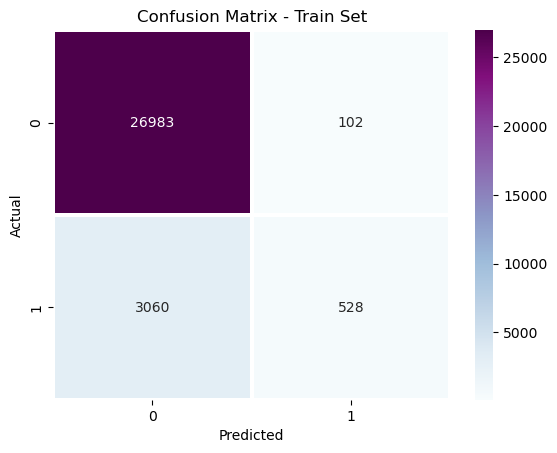

In [61]:
# Evaluate the model on training set
y_pred_train = best_xgb_model.predict(X_train)

# Confusion Matrix for Training Data
cm_train_xg = confusion_matrix(y_train, y_pred_train)
ax = sns.heatmap(cm_train_xg, annot=True, cmap='BuPu', fmt='g', linewidth=1.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')
plt.show()

## Test set

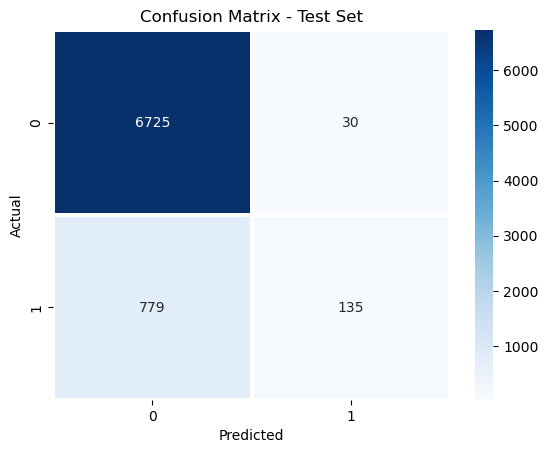

In [62]:
# Evaluate the model on test set
y_pred_test = best_xgb_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_xgb = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm_test_xgb, annot=True, cmap='Blues', fmt='g', linewidth=1.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')
plt.show()

In [63]:
# Number of goals in test set
print(f'The test dataset contains {len(y_test)} shots, with {y_test.sum()["is_goal"]} of them being goals.')

The test dataset contains 7669 shots, with 914 of them being goals.


## Feature importance

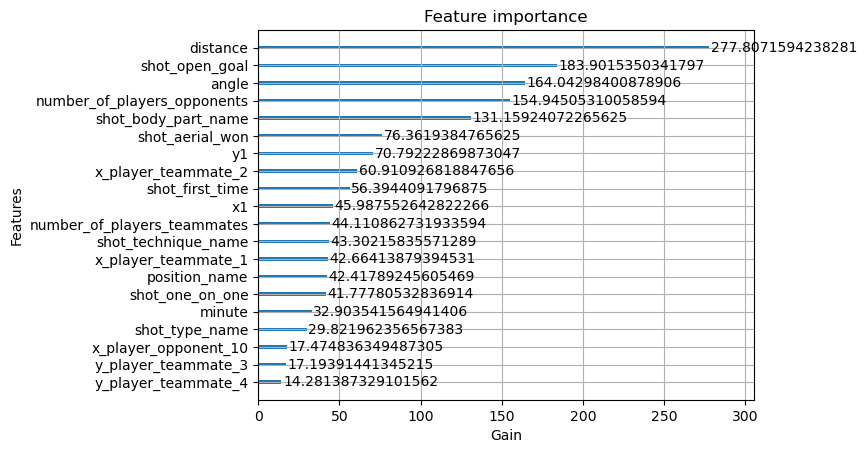

In [64]:
# Plot feature importance with Gain
xgboost.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain', max_num_features=20)
plt.show()

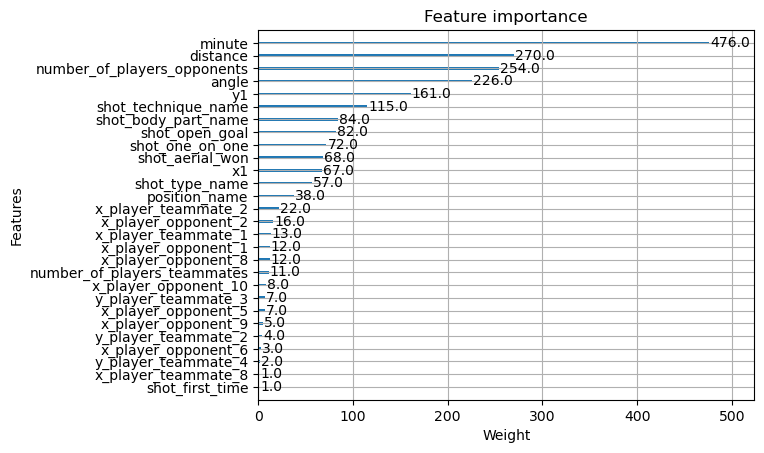

In [65]:
# Plot feature importance with Weight
xgboost.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight', max_num_features=30)
plt.show()

## Summary

In [66]:
# Calculating MAE, RMSE and R2 for training and test sets 
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)

In [67]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['XG Boost'],
                          'Training MAE': mae_train, 
                          'Training RMSE': rmse_train,
                          'Training R2':r2_train,
                          'Testing MAE': mae_test, 
                          'Testing RMSE': rmse_test,
                          'Testing R2':r2_test,
                          'Training Time (mins)': xgb_training_time/60})
summary_df.set_index('Model Name', inplace=True)

# Displaying summary of results
summary_df.style.format(precision =5).set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'white'})

# Keeping the xgboost model

In [68]:
# Save the model
best_xgb_model.save_model('xgboost.json')

best_xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [69]:
# Save the model
# dump(best_xgb_model, 'xgboost.joblib') 

# # Load the model
# model = load('xgboost.joblib')

In [70]:
best_xgb_model.predict_proba(X)

array([[0.9334918 , 0.06650815],
       [0.9150994 , 0.0849006 ],
       [0.9478227 , 0.05217729],
       ...,
       [0.77691543, 0.2230846 ],
       [0.9318629 , 0.06813709],
       [0.95634604, 0.04365399]], dtype=float32)

In [71]:
new_xgb_model = xgboost.XGBClassifier()
new_xgb_model.load_model('xgboost.json')

In [72]:
new_xgb_model.predict_proba(X)

array([[0.9334918 , 0.06650815],
       [0.9150994 , 0.0849006 ],
       [0.9478227 , 0.05217729],
       ...,
       [0.77691543, 0.2230846 ],
       [0.9318629 , 0.06813709],
       [0.95634604, 0.04365399]], dtype=float32)